In [1]:
D = lambda x, y: x + y * 8
queen_moves = sum(
    ([
        D(0, i), D(i, 0),
        D(0, -i), D(-i, 0),
        D(i,  i), D(-i,  i),
        D(i, -i), D(-i, -i),
    ]
    for i in xrange(1, 8)),
    []
)
knight_moves = [
    D( 1, 2), D( 1, -2),
    D(-1, 2), D(-1, -2),
    D( 2, 1), D( 2, -1),
    D(-2, 1), D(-2, -1),
]
all_layers = sorted(queen_moves + knight_moves)
assert len(all_layers) == 64
difference_to_layer_index = {diff: i for i, diff in enumerate(all_layers)}

def one_hot_to_large(move):
    assert move.shape == (2, 8, 8)
    pick_up, put_down = map(np.argmax, move)
    difference = put_down - pick_up
    result = np.zeros((len(all_layers), 64))
    result[difference_to_layer_index[difference], pick_up] = 1
    return result.reshape((len(all_layers), 8, 8))

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import glob, random, time, os, zlib
import model_merge as model

FEATURE_COUNT = 6 + 6 + 1
CROSS_VAL_SIZE = 1000 #3000
IN_SAMPLE_SIZE = 1000
MINIBATCH_SIZE = 512
DATA_ROOT = "final_output/"
TOTAL_CHUNK_COUNT = 22

def to_hms(x):
    x = int(x)
    seconds = x % 60
    minutes = (x // 60) % 60
    hours   = x // 60 // 60
    return "%2i:%02i:%02i" % (hours, minutes, seconds)

# For some reason some Python versions basically explode on .decode("zlib") for large strings.
# We can bypass by just decoding it in blocks ourself and assembling them.
def stream_decompress(s):
    decomp = zlib.decompressobj()
    block_size = 2**23
    i = 0
    results = []
    while i < len(s):
        block = s[i:i+block_size]
        results.append(decomp.decompress(block))
        i += block_size
    results.append(decomp.flush())
    return "".join(results)

def load_chunk(features, moves, outcomes):
    def load_flat_array(path, shape):
        with open(path) as f:
            data = f.read()
        data = stream_decompress(data)
        return np.fromstring(data, dtype=np.int8).reshape(shape)
    features = load_flat_array(features, (-1, 8, 8, FEATURE_COUNT))
    moves    = load_flat_array(moves, (-1, 2, 8, 8))
    outcomes = load_flat_array(outcomes, (-1, 1))
#    # Move each sample to be of shape (2, 8, 8) so we can use tf.nn.softmax_cross_entropy_with_logits_v2.
#   moves    = np.moveaxis(moves, -1, 1)
    assert len(features) == len(moves)
    return {"features": features, "moves": moves, "outcomes": outcomes}

# Views into the extremely large dataset.
next_chunk_index = 0
chunk = None
in_sample_test = None

def load_next_chunk():
    global next_chunk_index, chunk, in_sample_test
    print "    >>> Loading chunk:", next_chunk_index
    # Free the memory from the previous chunk FIRST, if we have one loaded.
    # This is necessary to avoid running out of memory.
    if chunk is not None:
        del chunk
        del in_sample_test
    start = time.time()
    chunk = load_chunk(
        os.path.join(DATA_ROOT, "features_%03i.z" % next_chunk_index),
        os.path.join(DATA_ROOT, "moves_%03i.z" % next_chunk_index),
        os.path.join(DATA_ROOT, "outcomes_%03i.z" % next_chunk_index),
    )
    next_chunk_index = (next_chunk_index + 1) % TOTAL_CHUNK_COUNT
    in_sample_test = {
        "features": chunk["features"][:IN_SAMPLE_SIZE],
        "moves":    map(one_hot_to_large, chunk["moves"][:IN_SAMPLE_SIZE]),
        "outcomes": chunk["outcomes"][:IN_SAMPLE_SIZE],
    }
    stop = time.time()
    print "    >>> (In %f) Samples: %i" % (stop - start, len(chunk["features"]))

def get_random_subset(samples, n):
    indices = random.sample(xrange(len(samples["features"])), n)
    return {
        "features": [samples["features"][i] for i in indices],
        "moves": [one_hot_to_large(samples["moves"][i]) for i in indices],
        "outcomes": [samples["outcomes"][i] for i in indices],
    }

In [3]:
load_next_chunk()
cross_val = load_chunk(
    os.path.join(DATA_ROOT, "test_features.z"),
    os.path.join(DATA_ROOT, "test_moves.z"),
    os.path.join(DATA_ROOT, "test_outcomes.z"),
)
random.seed(123456789)
cross_val = get_random_subset(cross_val, CROSS_VAL_SIZE)

    >>> Loading chunk: 0
    >>> (In 13.422875) Samples: 7840136


In [4]:
net = model.ChessNetwork("network/", build_training=True)
print "Total network parameters:", net.total_parameters
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
total_training_steps = 0
loss_plot = []
in_sample_loss_plot = []

Total network parameters: 2976641
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [5]:
model_save_counter = 0
def save_model():
    global model_save_counter
    model_save_counter += 1
    model.sess = sess
    model.save_model(net, "models/merge-001-10x128-model-%03i.npy" % model_save_counter)

In [6]:
total_work = 0.0
start_time = time.time()
best_loss = float("inf")
lr_schedule = lambda step: 0.001 * 0.5**(step / 80e3)

for overall_step in range(10000):
    lr = lr_schedule(total_training_steps)
    elapsed = time.time() - start_time
    in_sample_loss = net.get_loss(in_sample_test)
    loss = net.get_loss(cross_val)
    color_pair = "", ""
    if loss < best_loss:
        color_pair = "\x1b[31m", "\x1b[0m"
    message = "%s%6i [%s - %s] Loss: %.6f ~ %.6f  In-sample loss: %.6f ~ %.6f  Accuracy: %.3f  lr = %f%s" % (
        color_pair[0],
        total_training_steps,
        to_hms(elapsed),
        to_hms(total_work),
        loss[0],
        loss[1],
        in_sample_loss[0],
        in_sample_loss[1],
        net.get_accuracy(cross_val) * 100,
        lr,
        color_pair[1]
    )
    print(message)
    with open("/home/snp/chess_training_log", "a+") as f:
        print >>f, message
    loss_plot.append((total_training_steps, loss))
    in_sample_loss_plot.append((total_training_steps, in_sample_loss))
    best_loss = min(best_loss, loss)

    for _ in range(500):
        minibatch = get_random_subset(chunk, MINIBATCH_SIZE)
        working = time.time()
        net.train(minibatch, lr)
        total_work += time.time() - working
        # Try really hard to not keep any views around!
        del minibatch
        total_training_steps += 1

    # Periodically swap out the data for fresh training data.
    if (overall_step + 1) % 5 == 0:
        load_next_chunk()
    if (overall_step + 1) % 20 == 0:
        save_model()

     0 [ 0:00:00 -  0:00:00] Loss: 8.313370 ~ 0.615413  In-sample loss: 8.313459 ~ 0.719886  Accuracy: 0.500  lr = 0.002500
   500 [ 0:01:56 -  0:01:51] Loss: 5.076283 ~ 0.658102  In-sample loss: 5.026274 ~ 0.767051  Accuracy: 5.700  lr = 0.002478
  1000 [ 0:03:50 -  0:03:41] Loss: 3.672116 ~ 0.559185  In-sample loss: 3.554706 ~ 0.677978  Accuracy: 15.700  lr = 0.002457
  1500 [ 0:05:47 -  0:05:35] Loss: 3.558454 ~ 0.657544  In-sample loss: 3.514549 ~ 0.778633  Accuracy: 16.200  lr = 0.002436
  2000 [ 0:07:40 -  0:07:24] Loss: 3.615000 ~ 0.554458  In-sample loss: 3.486171 ~ 0.691499  Accuracy: 17.400  lr = 0.002415


KeyboardInterrupt: 

In [19]:
load_next_chunk()

    >>> Loading chunk: 1
    >>> (In 116.699438) Samples: 7840136


In [17]:
print net.get_loss(cross_val)

0.375092


In [12]:
np.average((chunk["moves"] - np.average(chunk["moves"])) ** 2.0)

0.43484994002044619

In [24]:
map(list(chunk["moves"]).count, (-1, 0, 1))

[95729, 325320, 614693]

In [29]:
x / float(sum(x))

array([ 0.09242553,  0.31409366,  0.59348081])

In [ ]:
load_next_chunk()

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = [12, 8]

In [ ]:
plt.hold(True)
plt.plot(*zip(*loss_plot))
plt.plot(*zip(*in_sample_loss_plot))

## Testing.

In [ ]:
print [int(chunk["features"][i].sum() == 96) for i in xrange(1000)]

In [ ]:
print [chunk["moves"][i].sum()+1 for i in xrange(1000)]

In [ ]:
print len(chunk["moves"])
print len(chunk["features"])

In [ ]:
chunk["moves"][:1000].flatten()

In [ ]:
for i in (-1, 0, 1):
    print i, list(chunk["moves"][:100000]).count(i)

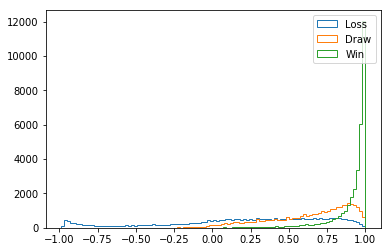

In [18]:
buckets = {-1: [], 0: [], 1: []}
src = chunk
#src = cross_val
for i in xrange(400):
    s = slice(1000 * i, 1000 * (i + 1))
    result = net.final_output.eval(feed_dict={
        net.input_ph: src["features"][s],
        net.desired_output_ph: src["moves"][s],
        net.is_training_ph: False,
    })
    for output, outcome in zip(result, src["moves"][s]):
        buckets[outcome[0]].append(output[0])
minlen = min(map(len, buckets.values()))
_ = plt.hist(buckets[-1][:minlen], bins=100, histtype="step")
_ = plt.hist(buckets[0][:minlen], bins=100, histtype="step")
_ = plt.hist(buckets[1][:minlen], bins=100, histtype="step")
plt.legend(["Loss", "Draw", "Win"])

In [ ]:
chunk["moves"].shape

In [ ]:
cross_val["moves"].shape

In [ ]:
cross_val["features"][0].shape

In [ ]:
sess.run(net.W2)

In [ ]:
np.moveaxis(chunk["features"][0], -1, 0)

In [ ]:
import utils
reload(utils)

In [ ]:
i = 0

In [ ]:
i += 1
print i, cross_val["moves"][i]
utils.features_to_board(cross_val["features"][i])

In [ ]:
src = chunk
src = cross_val
print "Average outcome:", np.array(src["moves"]).sum() / float(len(src["moves"]))

In [ ]:
v = ((chunk["moves"].flatten() - 0.052403045049218534) ** 2).sum()
v / len(chunk["moves"])

Evidence:

18 -- obviously won for white
37 -- looks plausibly like a draw
38 -- looks like a continuation of 37, and is still a draw
39 -- same
40 -- same
41 -- same
47 -- looks won for white
59 -- looks won for white, but reported as a draw? edit: according to TB, is a draw
70 -- looks won for black
75 -- looks won for black
90 -- looks won for white
91 -- looks won for white

In [ ]:
## Padding.

a

a

a

a

a

a

a

a

a

a

a

a
